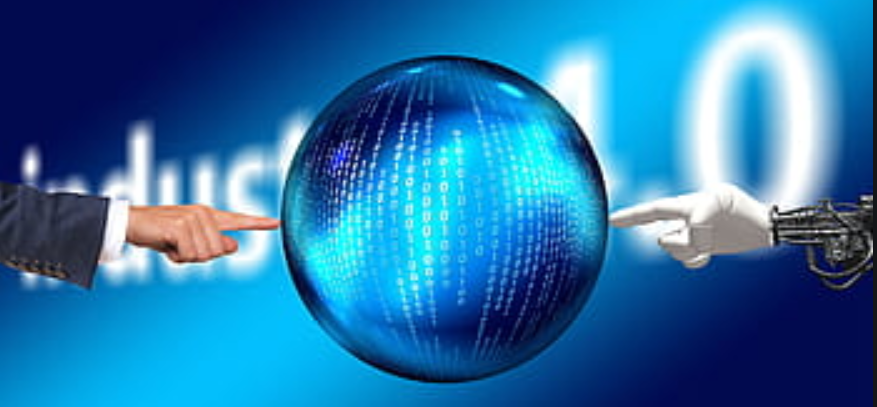

# Disclaimer! This kernel is only for educational purposes and made for fun therefor the content of the kernel should not be taken to seriously!

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Loading data

In [ ]:
import pandas as pd
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
train  = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
sample_submission = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

# Training data prep

In [ ]:
num_month = train['date_block_num'].max()
month_list=[i for i in range(num_month+1)]
shop = []
for i in range(num_month+1):
    shop.append(5)
item = []
for i in range(num_month+1):
    item.append(5037)
months_full = pd.DataFrame({'shop_id':shop, 'item_id':item,'date_block_num':month_list})
months_full

In [ ]:
train_clean = train.drop(labels = ['date', 'item_price'], axis = 1)
# change the item count per day to item count per month by using group
train_clean = train_clean.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
train_clean = train_clean.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
train_clean = train_clean[["item_id","shop_id","date_block_num","item_cnt_month"]]
train_clean

In [ ]:
clean= pd.merge(train_clean, train, how='right', on=['shop_id','item_id','date_block_num'])
clean = clean.sort_values(by=['date_block_num'])
clean.fillna(0.00,inplace=True)
clean

# Model prep

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = clean.copy()
X_test_full = clean.copy()

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['item_cnt_month'], inplace=True)
y = X_full.item_cnt_month
X_full.drop(['item_cnt_month'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# Pipeline/Model/Predict

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print(f'Model test accuracy: {clf.score(X_valid, y_valid)*100:.3f}%')

# Submissing

In [ ]:
# Add nan-values in the end of 'item_cnt_month', since there isnt as many rows in 'item_cnt_month'as in pred
sample_submission['item_cnt_month'] = pd.Series(preds)
sample_submission.apply(lambda col: col.drop_duplicates().reset_index(drop=True))

In [ ]:
#filling the missin nan-values with mean-values
sample_submission['item_cnt_month'].fillna(sample_submission['item_cnt_month'].median(), inplace = True)

In [ ]:
#make .csv file
sample_submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
if len(sample_submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(sample_submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")